**İsmail Sarp Erdem 32105**

# Movie Revenue Analysis & Prediction

**Objective:**  
- Explore how features like budget, popularity, and audience ratings relate to box-office revenue  
- Test specific hypotheses about these relationships  
- Build and compare predictive models (Linear Regression, Decision Tree, Random Forest)  
- Summarize key findings


In [ ]:
## **Movie Data Analysis Term Project DSA210**


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from scipy import stats
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model   import LinearRegression
from sklearn.tree           import DecisionTreeRegressor
from sklearn.ensemble       import RandomForestRegressor
from sklearn.preprocessing import StandardScaler


In [63]:
sns.set_theme(
    style="white",   
    context="talk",      
    palette="Set2")       

# 2) Tweak Matplotlib rcParams globally
plt.rcParams.update({
    "figure.figsize":    (10, 6),   
    "figure.dpi":         120,      
    "axes.titlesize":     18,
    "axes.labelsize":     14,
    "xtick.labelsize":    12,
    "ytick.labelsize":    12,
    "legend.fontsize":    12,
    "lines.linewidth":     2,
    "lines.markersize":    6,
    "grid.color":        "gray",
    "grid.linestyle":    "--",
    "grid.alpha":         0.3,
})


## 1. Data Loading & Merging

We load the TMDB “movies” and “credits” CSV files, then merge them on the `id` column so that each movie’s metadata and cast/crew info reside in one DataFrame.


In [ ]:
### **Data Process**

In [11]:
def load_and_merge(movies_path: str, credits_path: str) -> pd.DataFrame:
    movies = pd.read_csv(movies_path)
    credits = pd.read_csv(credits_path)
    df = pd.merge(movies, credits, left_on='id', right_on='movie_id', how='inner')
    return df

In [12]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    """Convert release_date to datetime, extract year, and engineer genre features."""
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
    df['year'] = df['release_date'].dt.year

    df['genre_list'] = df['genres'].apply(
        lambda x: [d['name'] for d in ast.literal_eval(x)]
    )
    df['primary_genre'] = df['genre_list'].apply(lambda lst: lst[0] if lst else None)
    df['genre_count'] = df['genre_list'].apply(len)

    df['runtime_bucket'] = pd.cut(
        df['runtime'],
        bins=[0, 90, 120, 150, np.inf],
        labels=['<=90', '91-120', '121-150', '150+']
    )
    return df


In [13]:
# Load and merge datasets
MOVIES_CSV  = 'tmdb_5000_movies.csv'
CREDITS_CSV = 'tmdb_5000_credits.csv'
df = load_and_merge(MOVIES_CSV, CREDITS_CSV)
df.head(10)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title_x,vote_average,vote_count,movie_id,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
5,258000000,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""na...",http://www.sonypictures.com/movies/spider-man3/,559,"[{""id"": 851, ""name"": ""dual identity""}, {""id"": ...",en,Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,115.699814,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,The battle within.,Spider-Man 3,5.9,3576,559,Spider-Man 3,"[{""cast_id"": 30, ""character"": ""Peter Parker / ...","[{""credit_id"": ""52fe4252c3a36847f80151a5"", ""de..."
6,260000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...",http://disney.go.com/disneypictures/tangled/,38757,"[{""id"": 1562, ""name"": ""hostage""}, {""id"": 2343,...",en,Tangled,When the kingdom's most wanted-and most charmi...,48.681969,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,

In [14]:
# Preprocess dataframe
df = preprocess(df)
df.head(10) ## Inside of the head() is arbitrary 

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,vote_count,movie_id,title_y,cast,crew,year,genre_list,primary_genre,genre_count,runtime_bucket
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,11800,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",2009.0,"[Action, Adventure, Fantasy, Science Fiction]",Action,4,150+
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,4500,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",2007.0,"[Adventure, Fantasy, Action]",Adventure,3,150+
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,4466,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",2015.0,"[Action, Adventure, Crime]",Action,3,121-150
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,9106,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",2012.0,"[Action, Crime, Drama, Thriller]",Action,4,150+
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,2124,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",2012.0,"[Action, Adventure, Science Fiction]",Action,3,121-150
5,258000000,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""na...",http://www.sonypictures.com/movies/spider-man3/,559,"[{""id"": 851, ""name"": ""dual identity""}, {""id"": ...",en,Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,115.699814,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,3576,559,Spider-Man 3,"[{""cast_id"": 30, ""character"": ""Peter Parker / ...","[{""credit_id"": ""52fe4252c3a36847f80151a5"", ""de...",2007.0,"[Fantasy, Action, Adventure]",Fantasy,3,121-150
6,260000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...",http://disney.go.com/disneypictures/tangled/,38757,"[{""id"": 1562, ""name"": ""hostage""}, {""id"": 2343,...",en,Tangled,When the kingdom's most wanted-and most charmi...,48.681969,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,3330,38757,Tangled,"[{""cast_id"": 34, ""character"": ""Flynn Rider (vo...","[{""credit_id"": ""52fe46db9251416c91062101"", ""de...",2010.0,"[Animation, Family]",Animation,2,91-120
7,280000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://marvel.com/movies/movie/193/avengers_ag...,99861,"[{""id"": 8828, ""name

### 2. Descriptive Statistics  
Summary statistics help us understand central tendencies and variability.


In [ ]:
## **Descriptive Statistics**

In [15]:
# Descriptive statistics for key numeric variables
numeric = ['budget', 'revenue', 'popularity', 'vote_count', 'vote_average', 'runtime', 'genre_count']
df[numeric].describe() 

,budget,revenue,popularity,vote_count,vote_average,runtime,genre_count
count,4.803000e+03,4.803000e+03,4803.000000,4803.000000,4803.000000,4801.000000,4803.000000
mean,2.904504e+07,8.226064e+07,21.492301,690.217989,6.092172,106.875859,2.531751
std,4.072239e+07,1.628571e+08,31.816650,1234.585891,1.194612,22.611935,1.120955
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.900000e+05,0.000000e+00,4.668070,54.000000,5.600000,94.000000,2.000000
50%,1.500000e+07,1.917000e+07,12.921594,235.000000,6.200000,103.000000,2.000000
75%,4.000000e+07,9.291719e+07,28.313505,737.000000,6.800000,118.000000,3.000000
max,3.800000e+08,2.787965e+09,875.581305,13752.000000,10.000000,338.000000,7.000000


### 2.1 Distributions  
Plot histograms, bar charts, boxplots and scatterplots to visualize the shape and outliers of each numeric feature.


In [ ]:
## **Categorical Distribution** 

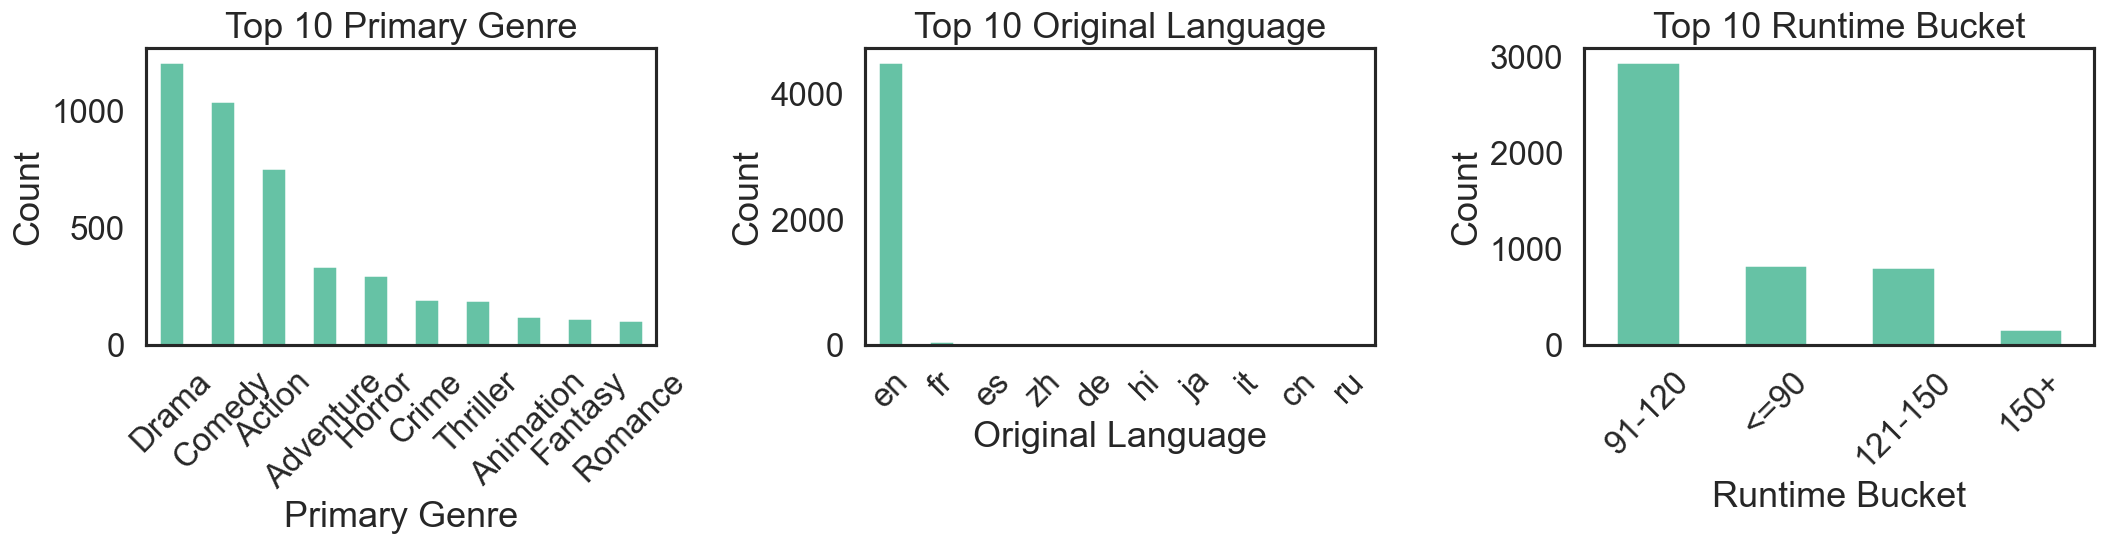

In [55]:
cats = ['primary_genre', 'original_language', 'runtime_bucket']
fig, axes = plt.subplots(1, len(cats), figsize=(18, 5))
for ax, var in zip(axes, cats):
    counts = df[var].value_counts().nlargest(10)
    counts.plot(kind='bar', ax=ax)
    ax.set_title(f'Top 10 {var.replace("_"," ").title()}')
    ax.set_xlabel(var.replace("_"," ").title())
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
##  **Boxplots**

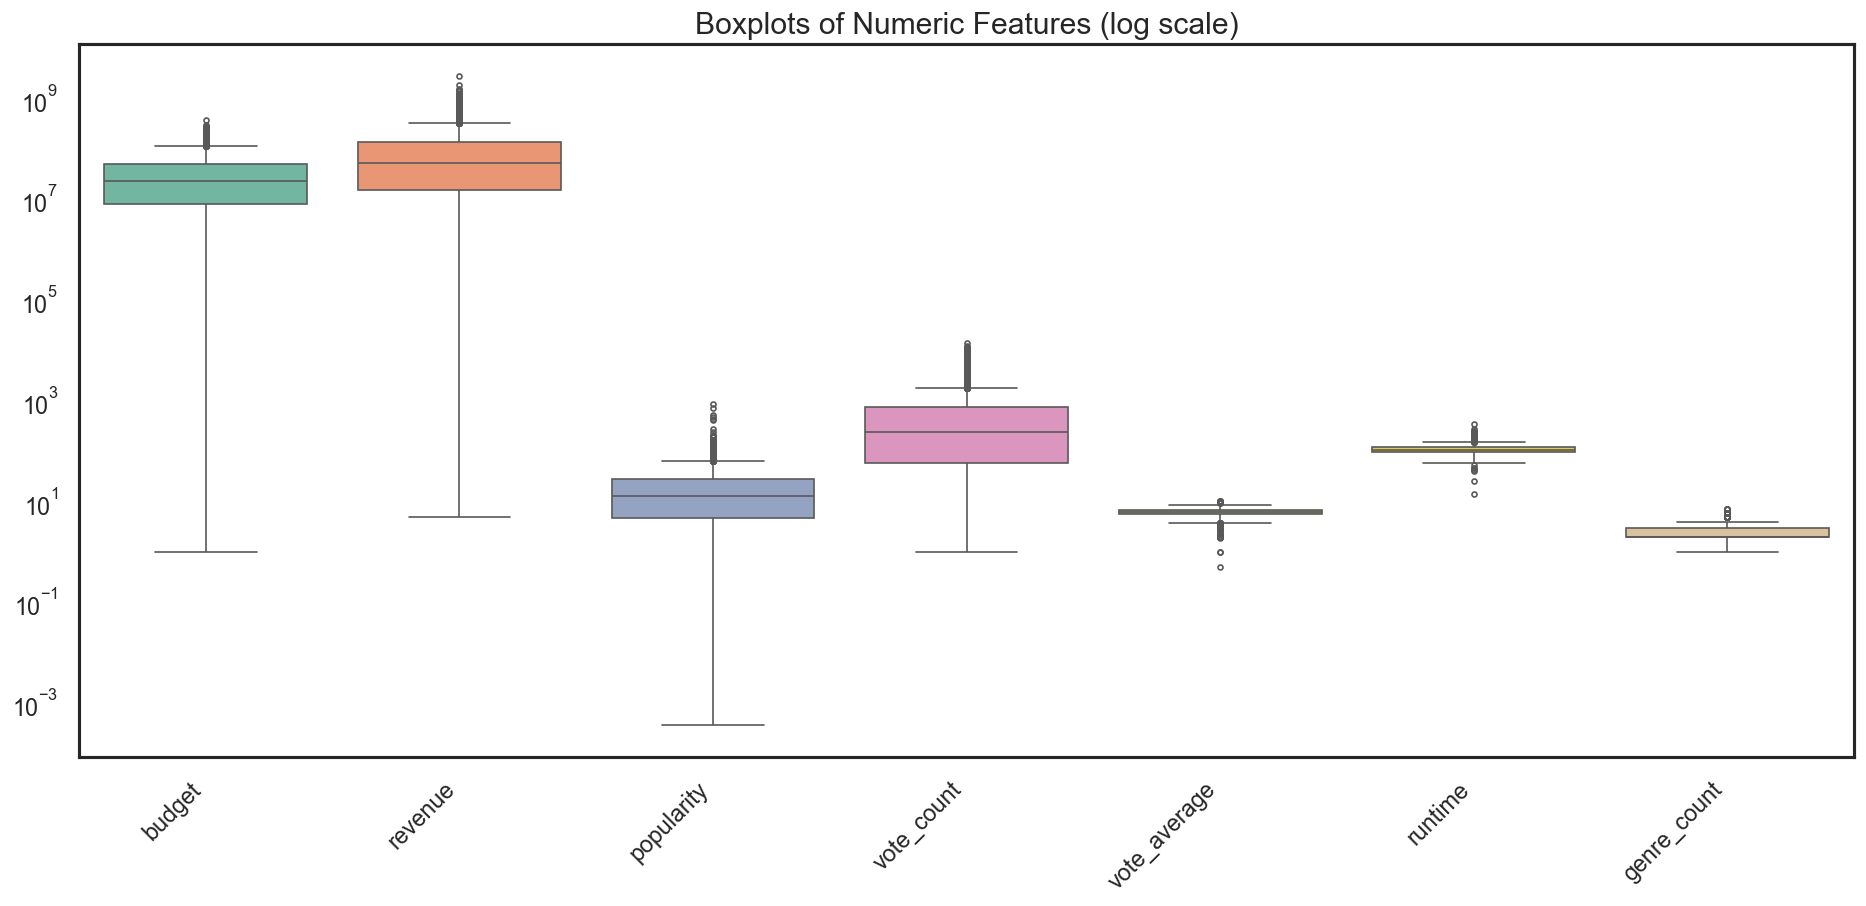

In [54]:
sns.set_context("talk", font_scale=1.2)

plt.figure(figsize=(16, 8))
df2 = df[numeric].replace(0, np.nan)
sns.boxplot(data=df2, fliersize=3)

plt.yscale('log')

plt.title("Boxplots of Numeric Features (log scale)", fontsize=18)
plt.xticks(rotation=45, ha="right", fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
 ## **Histograms**

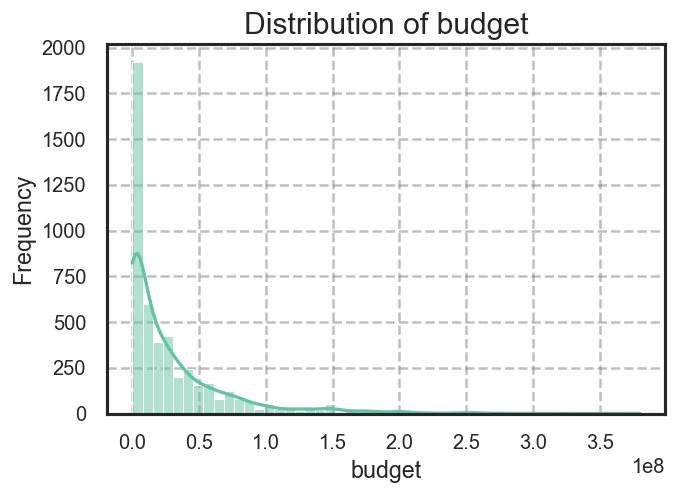

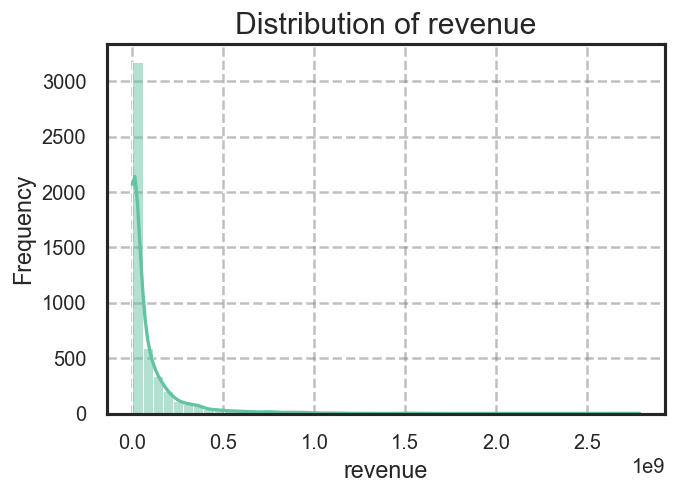

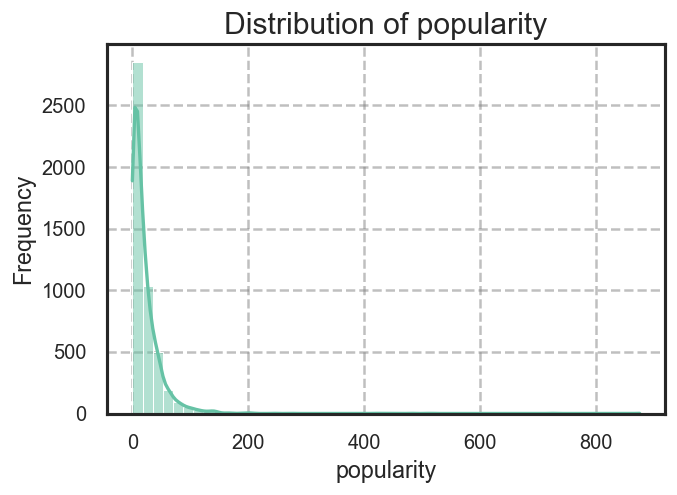

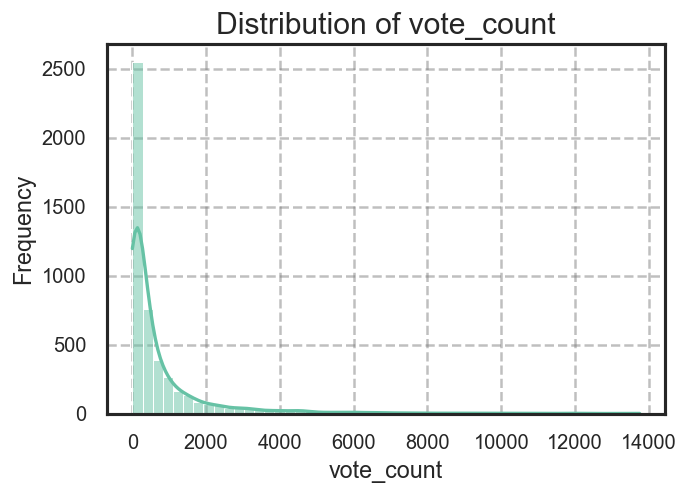

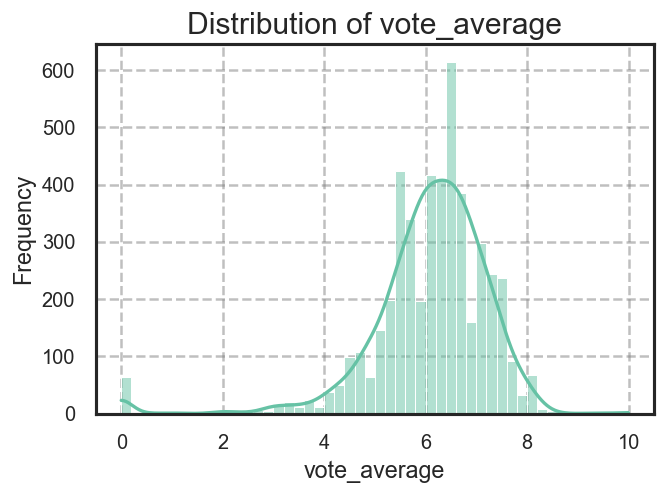

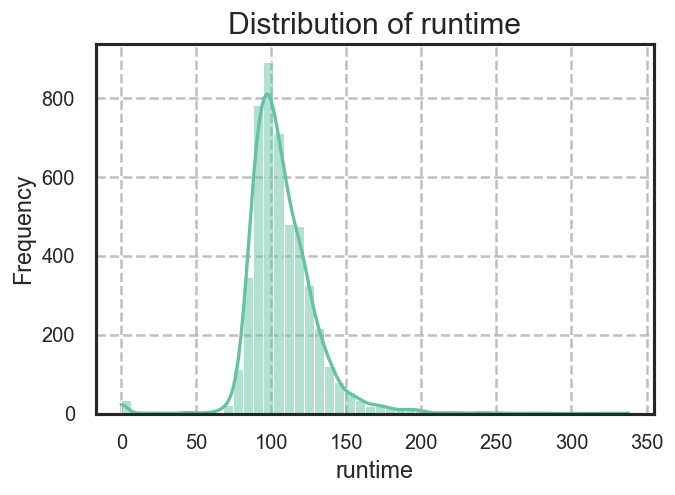

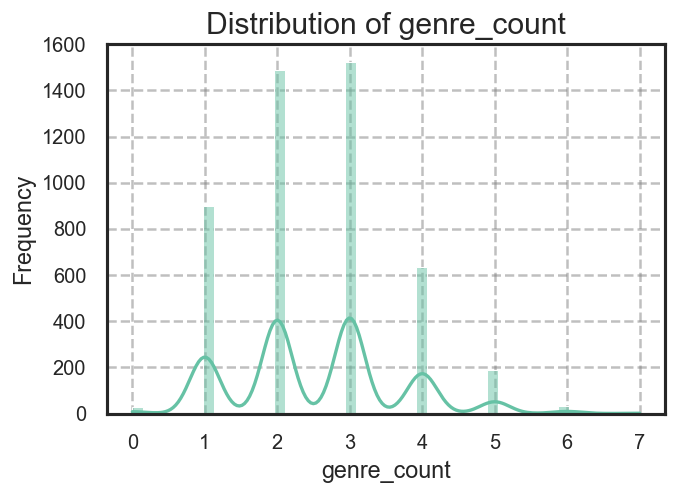

In [53]:
for col in numeric:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[col].dropna(),bins=50,kde=True,stat="count")
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

In [ ]:
## **Bar Chart**

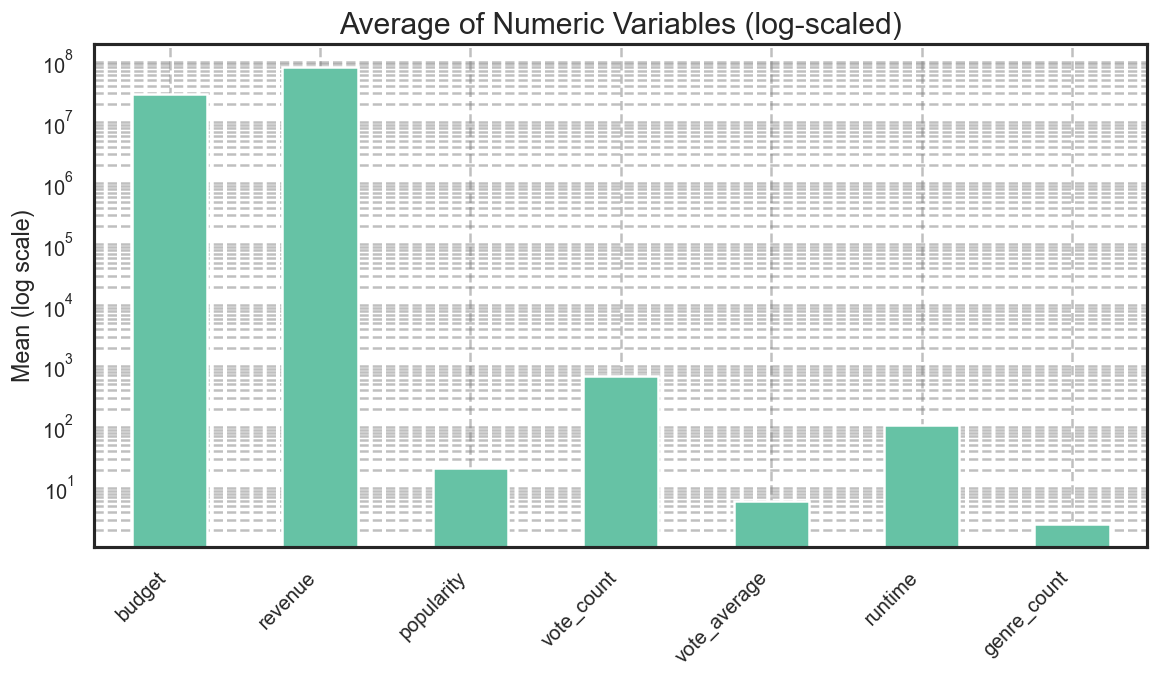

In [52]:
means = df[numeric].mean()

plt.figure(figsize=(10,6))
means.plot(kind='bar')
plt.yscale('log')
plt.ylabel('Mean (log scale)')
plt.title('Average of Numeric Variables (log-scaled)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5, which='both')
plt.tight_layout()
plt.show()



In [ ]:
## **Scatterplots** (numeric variables vs revenue)

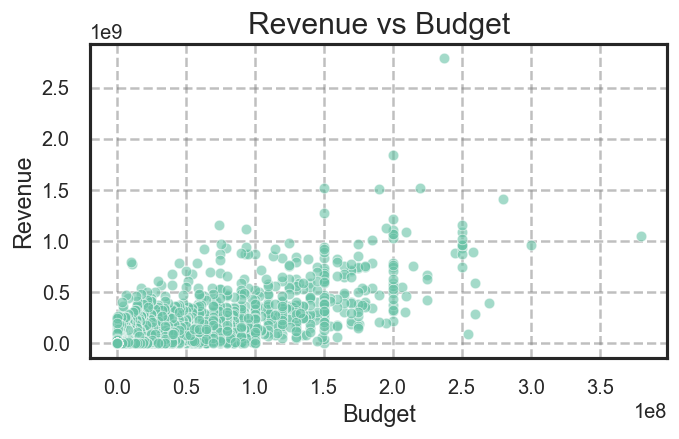

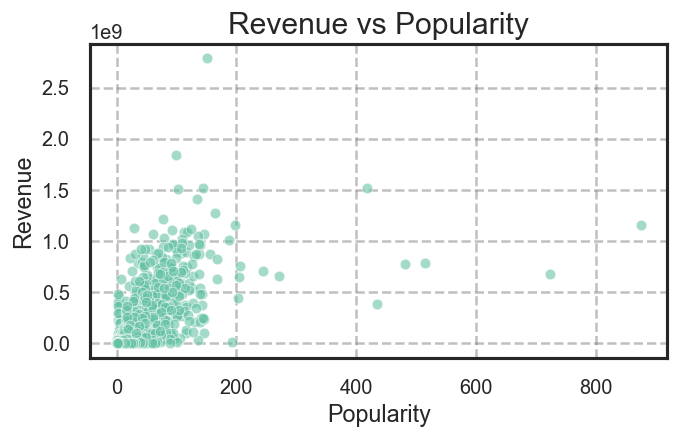

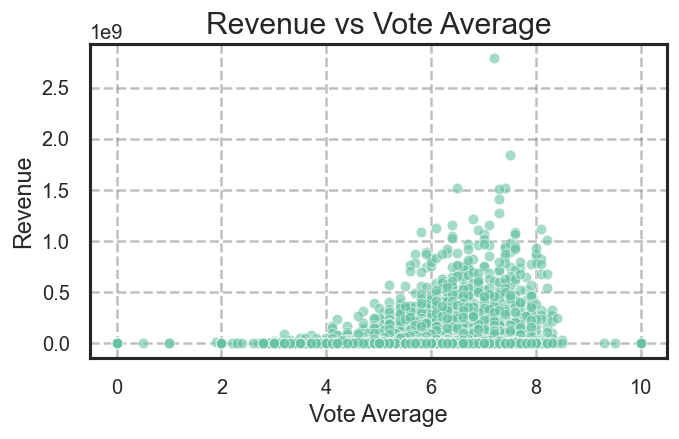

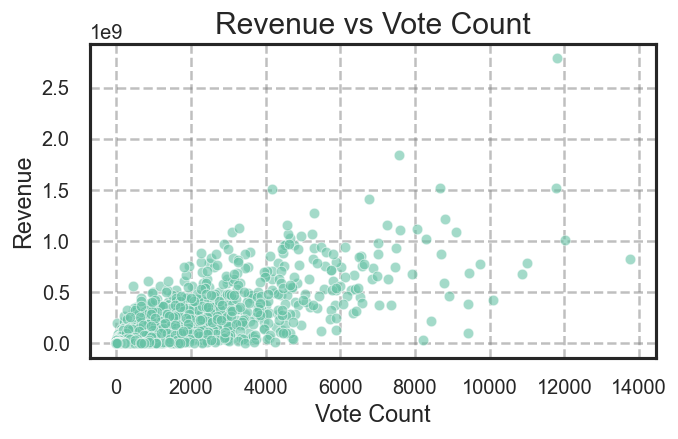

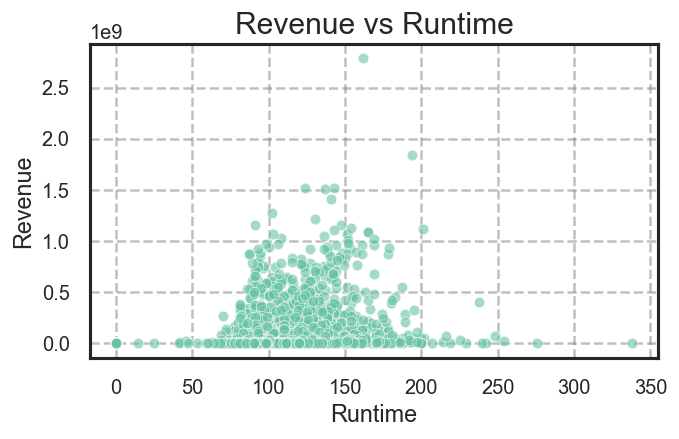

In [51]:
pairs = [
    ('budget',       'revenue'),
    ('popularity',   'revenue'),
    ('vote_average', 'revenue'),
    ('vote_count', 'revenue'),
    ('runtime', 'revenue'),
]

for x_var, y_var in pairs:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        data=df,
        x=x_var,
        y=y_var,
        alpha=0.6,    
        s=40          
    )
    plt.title(f'{y_var.replace("_"," ").title()} vs {x_var.replace("_"," ").title()}')
    plt.xlabel(x_var.replace("_"," ").title())
    plt.ylabel(y_var.replace("_"," ").title())
    plt.grid(linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [ ]:
## **Correlation Heatmap**


=== Correlation Matrix ===
                budget   revenue  popularity  vote_count  vote_average  \
budget        1.000000  0.730823    0.505414    0.593180      0.093146   
revenue       0.730823  1.000000    0.644724    0.781487      0.197150   
popularity    0.505414  0.644724    1.000000    0.778130      0.273952   
vote_count    0.593180  0.781487    0.778130    1.000000      0.312997   
vote_average  0.093146  0.197150    0.273952    0.312997      1.000000   
runtime       0.269851  0.251093    0.225502    0.271944      0.375046   
genre_count   0.269170  0.182185    0.154918    0.154000      0.085577   

               runtime  genre_count  
budget        0.269851     0.269170  
revenue       0.251093     0.182185  
popularity    0.225502     0.154918  
vote_count    0.271944     0.154000  
vote_average  0.375046     0.085577  
runtime       1.000000     0.098290  
genre_count   0.098290     1.000000  


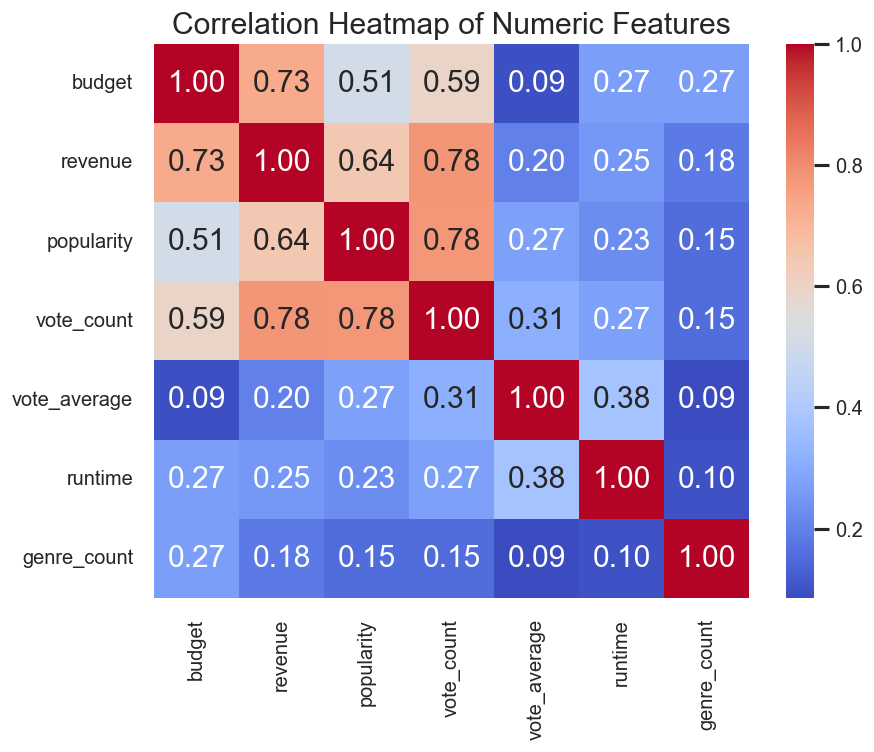

In [50]:
corr = df[numeric].corr()
print("\n=== Correlation Matrix ===")
print(corr)
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

### 2.2 Correlations  
Compute Pearson’s r for each pair to quantify linear relationships.


In [ ]:
## **Pearson Correlation**

In [22]:
def print_vs_revenue_pearson(df: pd.DataFrame, cols: list, target: str = 'revenue'):
    print(f"\n=== Pearson Correlation of Each Feature vs {target.title()} ===")
    for col in cols:
        if col == target:
            continue

        x = df[col]
        y = df[target]
        mask = x.notna() & y.notna()
        if mask.sum() < 2:
        
            continue

        r, p = stats.pearsonr(x[mask], y[mask])
        print(f"{col:12s} vs {target:12s} : r = {r:6.3f}, p = {p:.2e}")

In [23]:
print_vs_revenue_pearson(df, numeric)


=== Pearson Correlation of Each Feature vs Revenue ===
budget       vs revenue      : r =  0.731, p = 0.00e+00
popularity   vs revenue      : r =  0.645, p = 0.00e+00
vote_count   vs revenue      : r =  0.781, p = 0.00e+00
vote_average vs revenue      : r =  0.197, p = 2.72e-43
runtime      vs revenue      : r =  0.251, p = 6.25e-70
genre_count  vs revenue      : r =  0.182, p = 4.05e-37


In [ ]:
## r values shows the correlation between variables and revenue_

## 3. Hypothesis Testing

Testing:

1. **H₀**: No correlation between **budget** & **revenue**  
2. **H₁**: Positive correlation  
3. **H₀**: Mean revenue is the same for **high-rating** vs **low-rating** films  
4. **H₁**: Means differ  

Using Pearson’s test and a two-sample t-test.


In [ ]:
## **Hypothesis Tests **

In [24]:
def hypothesis_tests(df: pd.DataFrame):
    clean = df[['budget', 'revenue']].dropna()
    r, p = stats.pearsonr(clean['budget'], clean['revenue'])
    print("\n--- Hypothesis Test 1: Budget vs Revenue ---")
    print("H0: ρ = 0 (no correlation)\nHa: ρ ≠ 0 (non-zero correlation)")
    print(f"Pearson r = {r:.3f}, p-value = {p:.3e}")
    print("→", "Reject H0" if p < 0.05 else "Fail to reject H0")

    median_rating = df['vote_average'].median()
    grp_high = df[df['vote_average'] > median_rating]['revenue'].dropna()
    grp_low  = df[df['vote_average'] <= median_rating]['revenue'].dropna()
    t_stat, p_val = stats.ttest_ind(grp_high, grp_low, equal_var=False)
    print("\n--- Hypothesis Test 2: High vs Low Rating Revenue ---")
    print("H0: μ_high = μ_low\nHa: μ_high ≠ μ_low")
    print(f"t-statistic = {t_stat:.3f}, p-value = {p_val:.3e}")
    print("→", "Reject H0" if p_val < 0.05 else "Fail to reject H0")

In [25]:
hypothesis_tests(df)


--- Hypothesis Test 1: Budget vs Revenue ---
H0: ρ = 0 (no correlation)
Ha: ρ ≠ 0 (non-zero correlation)
Pearson r = 0.731, p-value = 0.000e+00
→ Reject H0

--- Hypothesis Test 2: High vs Low Rating Revenue ---
H0: μ_high = μ_low
Ha: μ_high ≠ μ_low
t-statistic = 10.824, p-value = 6.837e-27
→ Reject H0


Conclusion1: There is a highly significant, strong linear relationship between budget and revenue

Conclusion2: movies with above‐median ratings earn significantly more on average than lower‐rated ones. 


 Vote_count (how many users rate the film) and popularity are the strongest correlates of box‐office revenue.
 
 Budget is a strong candidate effecting revenue: larger production and marketing budgets yield higher revenues.
 
 Ratings (vote_average) play a mediocre role. While they don’t linearly track revenue as tightly, the t-test shows that 
 better‐rated movies still deliver a boost in mean earnings and revenue.
 
 Runtime and genre count have minimal linear effects on revenue.
 

## 4. Applying Machine Learning Techniques

* Using metrics (MSE, RMSE, R²) to objectively measure which approach best explains the variance in revenue.
Training three regressors to **predict revenue** from our numeric features.
1. Linear Regression  
2. Decision Tree
3. Random Forest  

We’ll compare them using RMSE and R².


In [ ]:
## **Linear Regression**

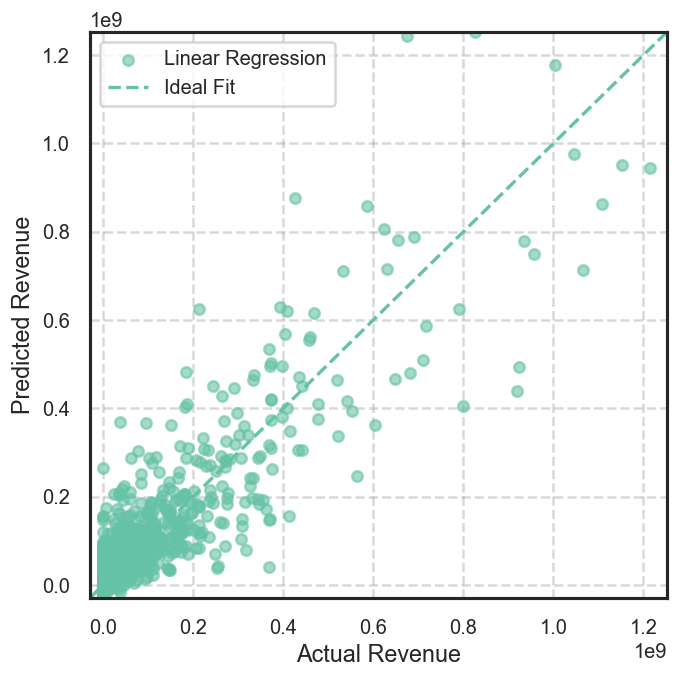

In [69]:

df['genre_count'] = df['genres'].apply(lambda x: len(ast.literal_eval(x)) if pd.notna(x) else 0)
numeric = ['budget','popularity','vote_count','vote_average','runtime','genre_count']


X = df[numeric]
y = df['revenue']
mask = X.notna().all(axis=1) & y.notna()
X, y = X[mask], y[mask]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


lr = LinearRegression().fit(X_train_scaled, y_train)
dt = DecisionTreeRegressor(max_depth=5, random_state=42).fit(X_train_scaled, y_train)
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train_scaled, y_train)


y_pred_lr = lr.predict(X_test_scaled)
y_pred_dt = dt.predict(X_test_scaled)
y_pred_rf = rf.predict(X_test_scaled)


def plot_actual_vs_predicted(name, y_true, y_pred, figsize=(6,6)):
    mse = mean_squared_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    plt.figure(figsize=figsize)
    plt.scatter(y_true, y_pred, alpha=0.6, s=40, label=name)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, '--', label='Ideal Fit')
    plt.xlabel('Actual Revenue')
    plt.ylabel('Predicted Revenue')
    plt.xlim(lims)
    plt.ylim(lims)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_actual_vs_predicted('Linear Regression', y_test, y_pred_lr)



In [70]:
## **Decision Tree**

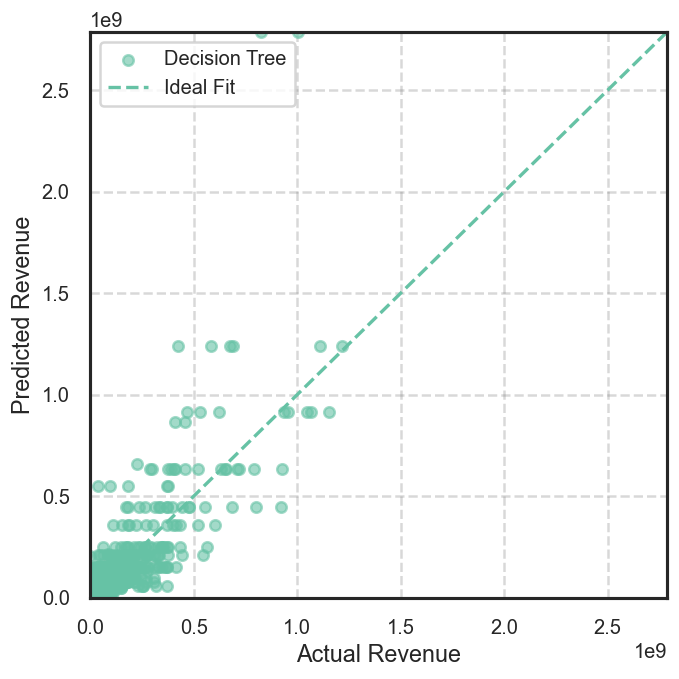

In [71]:
plot_actual_vs_predicted('Decision Tree',    y_test, y_pred_dt)

In [66]:
## **Random Forest**

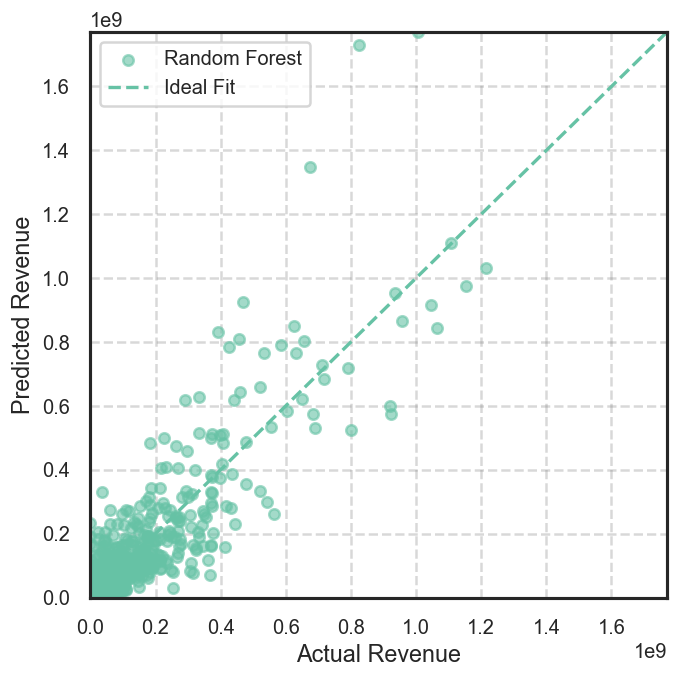

In [72]:
plot_actual_vs_predicted('Random Forest',    y_test, y_pred_rf)

In [ ]:
## **Model Performances**

In [73]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score


models = [
    ('Linear Regression', y_pred_lr),
    ('Decision Tree',     y_pred_dt),
    ('Random Forest',     y_pred_rf),
]

results = []
for name, y_pred in models:
    mse  = mean_squared_error(y_test, y_pred)
    rmse = mse**0.5
    r2   = r2_score(y_test, y_pred)
    results.append({
        'Model': name,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
    })

results_df = pd.DataFrame(results)
print("\n=== Model Performance Summary ===")
print(results_df.to_string(index=False))



=== Model Performance Summary ===
            Model          MSE         RMSE       R²
Linear Regression 6.287077e+15 7.929109e+07 0.760449
    Decision Tree 1.543640e+16 1.242433e+08 0.411841
    Random Forest 7.058418e+15 8.401439e+07 0.731059


## 4.2 **Conclusions**

**Key takeaways:**
- **Linear Regression** achieved the best performance on our test set (R² ≈ 0.76, RMSE ≈ $79 million), suggesting that most of the signal in revenue is captured by a linear combination of our numeric features.

- **Random Forest** came in a close second (R² ≈ 0.73, RMSE ≈ $84 million), showing that non‐linear interactions add value, but out‐of‐the‐box defaults didn’t surpass the simple linear trend.

- **Decision Tree**  underfit the data (R² ≈ 0.41, RMSE ≈ $124 million), indicating that a single shallow tree is too simple for this data.



